# Explore flood events in the Upper Severn
In this notebook we compare differences between rainfall estimates during floods in three catchments of the Upper Severn (Abermule, Dolwen and Plynlimon Flume).
We use data from the CEH-GEAR and HadUK-Grid.

## Table of contents
- [1. Load data](#1-load-data)  
- [2. Calc difference between CEH-GEAR and HadUK-Grid](#2-calculate-difference-between-haduk-to-ceh-gear)  
- [3. Examine Upper Severn high flow events](#3-examine-upper-severn-high-flow-events)  
    - [3.1. Single event](#31-look-at-a-single-high-flow-event)  
    - [3.1. Multiple events](#32-repeat-for-multiple-events)  
- [4. Compare datasets during high flow events by catchment](#4-compare-datasets-during-high-flow-events-by-catchment)

In [1]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import geopandas as gpd
import xarray as xr
import rioxarray

import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# utility functions required for this notebook
from utils import utils

### Globals for analysis

In [2]:
RAIN_COL = "rain_mm"
NEARBY_THRESHOLD_M = 2500 # metres
OVERLAP_THRESHOLD = 365*3 # three years
CARREG_GAUGE_ID = 420649

EASTING_RANGE = [279000, 324000] ## based on Abermule region
NORTHING_RANGE = [271000, 308000] ## based on Abermule region

In [43]:
## Severn-wide high flow events (from: https://github.com/Thomasjkeel/FDRI-catchment-contribution-to-floods)
severn_flood_dates = ['1984-11-13', '1986-12-16', '1986-12-19', '1988-03-16', '1988-03-20',\
    '1990-03-01', '1990-12-27', '1994-01-04', '1994-01-14', '1994-02-28',\
    '1994-04-05', '1994-04-10', '1995-01-22', '1995-12-24', '1996-02-13',\
    '2000-09-28', '2001-02-13', '2002-01-28', '2002-11-15', '2007-01-01',\
    '2008-03-17', '2008-11-11','2012-04-30','2013-02-15', '2020-01-15']
severn_flood_dates = [datetime.datetime.strptime(flood_date + ' 09:00', "%Y-%m-%d %H:%M") for flood_date in severn_flood_dates]

# 1. Load data
[Back to Index](#table-of-contents)

In [4]:
## Please see gridded_data for information on how to download 1km rainfall data
with open('../path_to_ceh_data.txt') as path:
    PATH_TO_CEHGEAR = path.read()

with open('../path_to_haduk_data.txt') as path:
    PATH_TO_HADUK = path.read()

## Load CEH-GEAR

In [5]:
ceh_severn = xr.open_dataset(f'{PATH_TO_CEHGEAR}/ceh_1km_severnregion_19700101_20230101.nc')
ceh_severn = ceh_severn.rename({'rainfall_amount': RAIN_COL})

ceh_abermule = ceh_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HadUK-Grid

In [6]:
haduk_severn = xr.open_mfdataset([f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19700101_19860831.nc',\
                f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19860901_20041231.nc',\
                 f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_20050101_20221231.nc'])
haduk_severn = haduk_severn.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_severn = haduk_severn.drop_vars(('latitude', 'longitude'))
haduk_severn['time'] = haduk_severn['time'].dt.floor(freq='D')

haduk_abermule = haduk_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HGHT grid

In [7]:
severn_hght = rioxarray.open_rasterio('../catchment_boundaries/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [8]:
## monthly gauges
severn_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_severn.csv', try_parse_dates=True)
severn_monthly_gauges = utils.convert_time_to_hour_base(severn_monthly_gauges, hour=9, time_col='START_DATE')
severn_monthly_gauges = utils.convert_time_to_hour_base(severn_monthly_gauges, hour=9, time_col='END_DATE')

In [9]:
## Load gauge data (QC'd version)
severn_all_gauges = pl.read_csv('../gauge_data/mo_daily_severn_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
severn_all_gauges = utils.convert_time_to_hour_base(severn_all_gauges, hour=9)

In [10]:
# daily metadata
severn_metadata = pl.read_csv('../gauge_data/mo_severn_metadata.csv')

In [11]:
# Check for monthly only gauges in metadata
severn_metadata = severn_metadata.with_columns(
    (pl.col("ID").is_in(severn_monthly_gauges['ID']) & ~pl.col("ID").is_in(severn_all_gauges['gauge_id'].unique())).alias('IS_ONLY_MONTHLY_GAUGE')
)

severn_metadata = severn_metadata.with_columns(
    (~pl.col("ID").is_in(severn_monthly_gauges['ID']) & pl.col("ID").is_in(severn_all_gauges['gauge_id'].unique())).alias('IS_ONLY_DAILY_GAUGE')
)

print(severn_metadata['IS_ONLY_DAILY_GAUGE'].value_counts())
print(severn_metadata['IS_ONLY_MONTHLY_GAUGE'].value_counts())

shape: (2, 2)
┌─────────────────────┬───────┐
│ IS_ONLY_DAILY_GAUGE ┆ count │
│ ---                 ┆ ---   │
│ bool                ┆ u32   │
╞═════════════════════╪═══════╡
│ true                ┆ 335   │
│ false               ┆ 296   │
└─────────────────────┴───────┘
shape: (2, 2)
┌───────────────────────┬───────┐
│ IS_ONLY_MONTHLY_GAUGE ┆ count │
│ ---                   ┆ ---   │
│ bool                  ┆ u32   │
╞═══════════════════════╪═══════╡
│ false                 ┆ 612   │
│ true                  ┆ 19    │
└───────────────────────┴───────┘


## Load shapefiles

In [12]:
abermule_shp = gpd.read_file('../catchment_boundaries/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('../catchment_boundaries/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('../catchment_boundaries/Plynlimon Flume/54022/54022.shp')

# 2. Calculate difference between HadUK to CEH-GEAR
[Back to Index](#table-of-contents)

## Shift grid
Because the two gridded datasets are on a different grid, we need to shift CEH-GEAR 500 metres in the X and Y dimension

In [13]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data


In [14]:
ceh_abermule_shifted = coerse_data_into_haduk_format(ceh_abermule, offset=500, xrange=slice(*EASTING_RANGE), yrange=slice(*NORTHING_RANGE))

In [15]:
## add height variable to shifted CEH data
ceh_abermule_shifted['hght'] = severn_hght

## Get difference between HadUK to CEH-GEAR

In [16]:
ceh_abermule_shifted = ceh_abermule_shifted.sel(time=slice(haduk_abermule['time'].min(), haduk_abermule['time'].max()))

In [17]:
ceh_haduk_diff = ceh_abermule_shifted['rain_mm'] - haduk_abermule['rain_mm']
diff_col_name = f'{RAIN_COL}_diff'
ceh_haduk_diff = ceh_haduk_diff.to_dataset(name=diff_col_name)
ceh_haduk_diff['hght'] = severn_hght
ceh_haduk_diff['min_dist'] = ceh_abermule_shifted['min_dist']

In [18]:
ALL_METADATA = severn_metadata
ALL_GAUGE_DATA = severn_all_gauges
CEH_DATA = ceh_abermule
HADUK_DATA = haduk_abermule

# Gauge class required for analysis
The following class ('Gauge') will allow us to quickly extract information from a rain gauge (i.e. metadata, nearby gauges, etc) using its ID

In [19]:
class Gauge:
    def __init__(self, gauge_id, nearby_threshold_m=NEARBY_THRESHOLD_M):
        self.gauge_id = int(gauge_id)
        self.gauge_metadata = self._get_gauge_metadata()
        self.gauge_easting = self.gauge_metadata['EASTING'].item()
        self.gauge_northing = self.gauge_metadata['NORTHING'].item()
        self.gauge_data = self._get_gauge_data()
        self.nearby_gauges = self._get_nearby_gauges(nearby_threshold_m)
        self.closest_cehgear = self._get_closest_gridded_data(CEH_DATA, nearby_threshold_m)
        self.closest_haduk = self._get_closest_gridded_data(HADUK_DATA, nearby_threshold_m)

    def _get_gauge_metadata(self):
        assert self.gauge_id in ALL_METADATA['ID'],\
            f"Gauge id={self.gauge_id} is not in the gauge metadata"
        return ALL_METADATA.filter(pl.col("ID") == self.gauge_id)

    def _get_gauge_data(self):
        assert self.gauge_id in ALL_GAUGE_DATA['gauge_id'],\
            f"Gauge id={self.gauge_id} is not in the gauge data"
        return ALL_GAUGE_DATA.filter(pl.col("gauge_id") == self.gauge_id)

    def _get_nearby_gauges(self, nearby_threshold_m):
        nearby_gauge_metadata = ALL_METADATA.filter((pl.col('EASTING') >= self.gauge_easting-nearby_threshold_m)\
                                                & (pl.col('EASTING') <= self.gauge_easting+nearby_threshold_m) &\
            (pl.col('NORTHING') >= self.gauge_northing-nearby_threshold_m) & (pl.col('NORTHING') <= self.gauge_northing+nearby_threshold_m))
        return nearby_gauge_metadata['ID'].to_list()

    def _get_closest_gridded_data(self, gridded_data, closeness_threshold_m):
        """TODO: needs testing with data that is off grid"""
        closest_grid_cell = gridded_data.sel(x=self.gauge_easting, y=self.gauge_northing, method='nearest')
        distance_x, distance_y = abs(self.gauge_easting-closest_grid_cell['x']), abs(self.gauge_northing-closest_grid_cell['y'])
        if distance_x > closeness_threshold_m or distance_y > closeness_threshold_m:
            raise ValueError(f"Closest data point in grid is more than {closeness_threshold_m} m away in X ({distance_x} m), or Y ({distance_y} m)")
        return closest_grid_cell

    def get_nearby_gridded_data(self, gridded_data, nearby_radius_m):
        nearby_grid_cells = gridded_data.sel(x=slice(self.gauge_easting-nearby_radius_m, self.gauge_easting+nearby_radius_m),\
                                y=slice(self.gauge_northing-nearby_radius_m, self.gauge_northing+nearby_radius_m))
        return nearby_grid_cells


def get_combined_gauge_data(gauge, how='left'):
    assert isinstance(gauge, Gauge), "data should be of Gauge type"
    closest_ceh = pl.from_pandas(gauge.closest_cehgear[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_ceh').reset_index())
    closest_ceh = utils.convert_time_to_hour_base(closest_ceh, hour=9)
    closest_haduk = pl.from_pandas(gauge.closest_haduk[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_haduk').reset_index())
    closest_haduk = utils.convert_time_to_hour_base(closest_haduk, hour=9)
    combined_data = gauge.gauge_data[['time', f'{RAIN_COL}_gauge']].join(closest_ceh, on='time', how=how)
    combined_data = combined_data.join(closest_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data


def get_combined_gauge_data_w_nearby(gauge, nearby_radius_m=NEARBY_THRESHOLD_M, how='left'):
    combined_data = get_combined_gauge_data(gauge, how=how)
    gauge.nearby_ceh = gauge.get_nearby_gridded_data(CEH_DATA, nearby_radius_m)
    gauge.nearby_haduk = gauge.get_nearby_gridded_data(HADUK_DATA, nearby_radius_m)
    nearby_ceh = pl.from_pandas(gauge.nearby_ceh[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_ceh').reset_index())
    nearby_ceh = utils.convert_time_to_hour_base(nearby_ceh, hour=9)
    nearby_haduk = pl.from_pandas(gauge.nearby_haduk[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_haduk').reset_index())
    nearby_haduk = utils.convert_time_to_hour_base(nearby_haduk, hour=9)
    combined_data = combined_data.join(nearby_ceh, on='time', how=how)
    combined_data = combined_data.join(nearby_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data

# 3. Examine Upper Severn high flow events
[Back to Index](#table-of-contents)

In [20]:
DAYS_BEFORE_FLOOD = 10

In [21]:
def get_date_ndays_before(one_date, ndays):
    return one_date-datetime.timedelta(days=ndays)

In [22]:
def get_data_ndays_before_flood_date(data, flood_date, ndays):
    days_before = get_date_ndays_before(flood_date, ndays=ndays)
    return data.filter(
        (pl.col("time") >= days_before) & (pl.col("time") <= flood_date)
    )

In [23]:
nearby_threshold_m = 100000 # set high to get all gauges within abermule region
carreg_gauge_wide_neighbours = Gauge(CARREG_GAUGE_ID, nearby_threshold_m=nearby_threshold_m)

In [24]:
CARREG_COORDS = {'Easting': carreg_gauge_wide_neighbours.gauge_easting, 'Northing': carreg_gauge_wide_neighbours.gauge_northing}



In [25]:
carreg_w_nearby = get_combined_gauge_data_w_nearby(carreg_gauge_wide_neighbours, how='right')
carreg_w_nearby = carreg_w_nearby.sort(by='time')
carreg_w_nearby.head()

rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,time,rain_mm_nearby_haduk
f64,f64,f64,f64,datetime[μs],f64
null,6.8,7.322106,6.743333,1970-01-01 09:00:00,6.72146
null,5.0,5.800373,4.756667,1970-01-02 09:00:00,4.863208
null,0.9,0.839409,0.9,1970-01-03 09:00:00,0.845184
null,0.0,0.018795,0.006667,1970-01-04 09:00:00,0.029259
null,6.8,7.435493,6.266667,1970-01-05 09:00:00,6.29727


## 3.1 Look at a single high flow event
[Back to Index](#table-of-contents)

In [44]:
## select a single flood event
flood_date = severn_flood_dates[-1]

In [45]:
## subset data by flood date
ceh_abermule_for_flood = ceh_abermule.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))

ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood[diff_col_name].mean('time')

In [46]:
## get nearby gauge data summary
nearby_gauge_dict = {}
for gauge_id in carreg_gauge_wide_neighbours.nearby_gauges:
    try:
        nearby_gauge = Gauge(gauge_id, nearby_threshold_m=nearby_threshold_m)
        rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
        mean_rain_ndays_before = rain_ndays_before.mean()[f'{RAIN_COL}_gauge'].item()
        assert mean_rain_ndays_before, "No data during flood event"
    except AssertionError:
        continue
    nearby_ceh = ceh_abermule_for_flood[RAIN_COL].sel(x=nearby_gauge.gauge_easting, y=nearby_gauge.gauge_northing, method='nearest').load()
    nearby_ceh_df = utils.convert_time_to_hour_base(pl.from_dataframe(nearby_ceh.to_dataframe().reset_index()), hour=9)
    nearby_gauge_dict[gauge_id] = {}
    nearby_gauge_dict[gauge_id]['easting'] = nearby_gauge.gauge_easting
    nearby_gauge_dict[gauge_id]['northing'] = nearby_gauge.gauge_northing
    rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
    rain_ndays_before = rain_ndays_before.sort(by='time')
    nearby_ceh_df_joined = nearby_ceh_df.join(rain_ndays_before, on='time', how='full')
    nearby_gauge_dict[gauge_id]['mean_diff_rain_mm'] = (nearby_ceh_df_joined['rain_mm'] - nearby_ceh_df_joined['rain_mm_gauge']).mean()


In [47]:
nearby_gauge_df = pd.DataFrame.from_dict(nearby_gauge_dict).T.reset_index(names='gauge_id')
nearby_gauge_df.round(2)

,gauge_id,easting,northing,mean_diff_rain_mm
0,90358,379831.0,331185.0,0.44
1,91862,381595.0,322447.0,-0.27
2,421234,291018.0,287054.0,0.00
3,421484,302044.0,289380.0,-0.04
4,423144,304130.0,302560.0,0.11
...,...,...,...,...
76,545177,315606.0,332789.0,-3.71
77,545178,315606.0,332789.0,-3.39
78,545450,329429.0,337265.0,-2.19
79,545694,334477.0,340663.0,-0.69


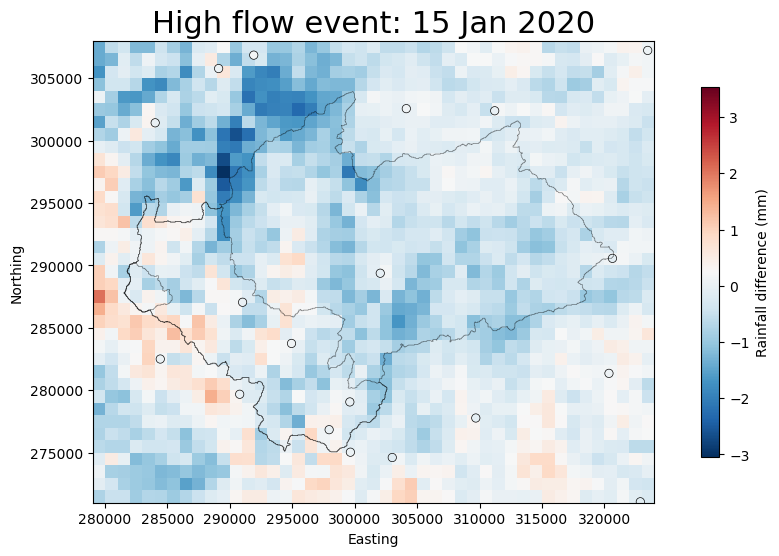

In [55]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)

rain_vmax = float(max(abs(ceh_haduk_diff_for_flood_mean.min()), ceh_haduk_diff_for_flood_mean.max()).load())+0.5
rain_vmin = -rain_vmax+0.5
used_cmap = plt.get_cmap('RdBu_r')
cmap_norm = plt.Normalize(rain_vmin, rain_vmax)

ceh_haduk_diff_for_flood_mean.plot(ax=ax, cmap=used_cmap, vmin=rain_vmin, vmax=rain_vmax, center=0, cbar_kwargs={'label': 'Rainfall difference (mm)', 'shrink': 0.8})

sns.scatterplot(x='easting', y='northing', hue='mean_diff_rain_mm', data=nearby_gauge_df.round(2),\
        hue_norm=(rain_vmin, rain_vmax), palette='RdBu_r', ax=ax, legend=False, edgecolor='k')
ax.set_xlabel('Easting'); ax.set_ylabel('Northing');
abermule_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5, linewidth=.5)
ax.set_title(f'High flow event: {flood_date.strftime('%d %b %Y')}', size=22)
plt.subplots_adjust(hspace=.2)
# fig.savefig(f'../figures/upper_severn_floods/ceh_vs_haduk_grid_vs_gauge_flood_{flood_date.strftime('%d_%b_%Y')}.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
- 

## 3.2 Repeat for multiple events
[Back to Index](#table-of-contents)

In [56]:
six_floods_to_view = severn_flood_dates[-6:]

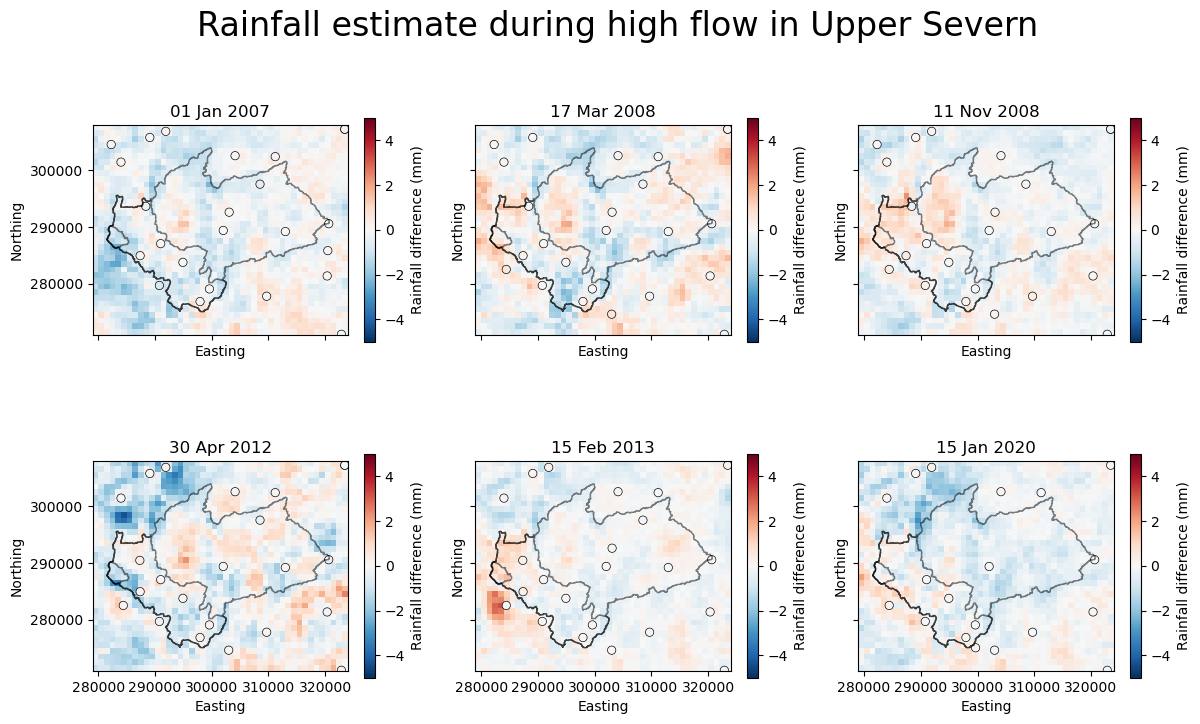

In [67]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

rain_vmin = -5
rain_vmax = 5
used_cmap = plt.get_cmap('RdBu_r')
cmap_norm = plt.Normalize(rain_vmin, rain_vmax)

for flood_date, ax in zip(six_floods_to_view, axes.flatten()):
    ## get CEH-GEAR data
    ceh_abermule_for_flood = ceh_abermule.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood[diff_col_name].mean('time')

    ## get nearby gauges rain
    nearby_gauge_dict = {}
    for gauge_id in carreg_gauge_wide_neighbours.nearby_gauges:
        try:
            nearby_gauge = Gauge(gauge_id, nearby_threshold_m=nearby_threshold_m)
            rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
            mean_rain_ndays_before = rain_ndays_before.mean()[f'{RAIN_COL}_gauge'].item()
            assert mean_rain_ndays_before, "No data during flood event"
        except AssertionError:
            continue
        nearby_diff = ceh_abermule_for_flood[RAIN_COL].sel(x=nearby_gauge.gauge_easting, y=nearby_gauge.gauge_northing, method='nearest').load()
        nearby_diff_df = utils.convert_time_to_hour_base(pl.from_dataframe(nearby_diff.to_dataframe().reset_index()), hour=9)
        nearby_diff_df_joined = nearby_diff_df.join(rain_ndays_before, on='time', how='full')
        nearby_gauge_dict[gauge_id] = {}
        nearby_gauge_dict[gauge_id]['easting'] = nearby_gauge.gauge_easting
        nearby_gauge_dict[gauge_id]['northing'] = nearby_gauge.gauge_northing
        rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
        rain_ndays_before = rain_ndays_before.sort(by='time')
        nearby_gauge_dict[gauge_id]['mean_diff_rain_mm'] = (nearby_diff_df_joined['rain_mm'] - nearby_diff_df_joined['rain_mm_gauge']).mean()
    nearby_gauge_df = pd.DataFrame.from_dict(nearby_gauge_dict).T.reset_index(names='gauge_id')

    ## plot data
    ceh_haduk_diff_for_flood_mean.plot(ax=ax, cmap='RdBu_r', vmin=rain_vmin, vmax=rain_vmax, center=0, cbar_kwargs={'label': 'Rainfall difference (mm)', 'shrink': 0.8})

    sns.scatterplot(x='easting', y='northing', hue='mean_diff_rain_mm', data=nearby_gauge_df.round(2),\
            hue_norm=(rain_vmin, rain_vmax), palette='RdBu_r', ax=ax, legend=False, edgecolor='k')
    abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
    dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_title(f'{flood_date.strftime('%d %b %Y')}')
    ax.set_xlabel('Easting'); ax.set_ylabel('Northing');

plt.suptitle("Rainfall estimate during high flow in Upper Severn", size=24)
plt.subplots_adjust(wspace=.2)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_events_differences.png', bbox_inches='tight', dpi=200)


### ⭐ Intepretation of above figure:
- 

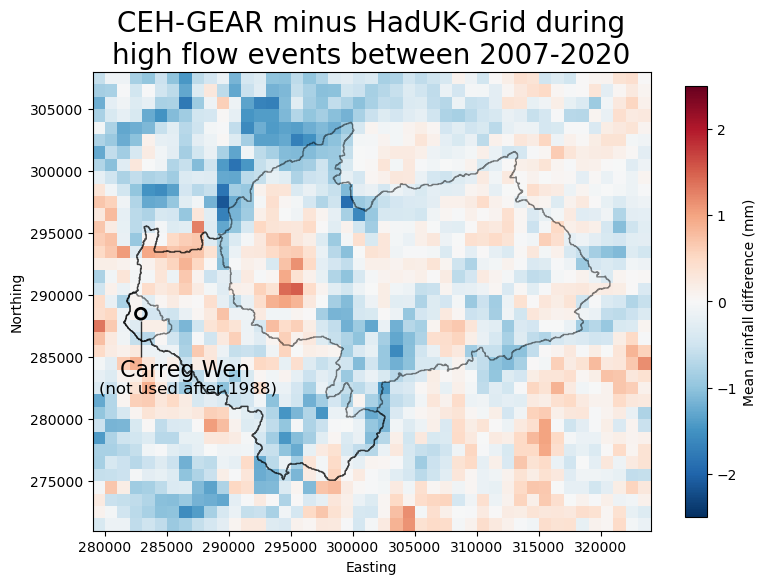

In [73]:
fig, ax = plt.subplots(1, figsize=(9, 7))

rain_vmin = -2.5
rain_vmax = 2.5
used_cmap = plt.get_cmap('RdBu_r')
cmap_norm = plt.Normalize(rain_vmin, rain_vmax)

for ind, flood_date in enumerate(six_floods_to_view):
    ## get CEH-GEAR data
    ceh_abermule_for_flood = ceh_abermule.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood[diff_col_name].mean('time')
    if ind == 0:
        all_ceh_haduk_diff_for_flood_sum = ceh_haduk_diff_for_flood_mean
    else:
        all_ceh_haduk_diff_for_flood_sum += ceh_haduk_diff_for_flood_mean
## plot data
all_ceh_haduk_diff_for_flood_mean = (all_ceh_haduk_diff_for_flood_sum/len(six_floods_to_view)).load()
all_ceh_haduk_diff_for_flood_mean.plot(ax=ax, cmap='RdBu_r', vmin=rain_vmin, vmax=rain_vmax, center=0, cbar_kwargs={'label': 'Mean rainfall difference (mm)', 'shrink': 0.8})

abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
ax.set_xlabel('Easting'); ax.set_ylabel('Northing');
ax.scatter(x=CARREG_COORDS['Easting'], y=CARREG_COORDS['Northing'], marker='o', edgecolor='k', facecolor='None', s=60, linewidths=2)
ax.text(s='Carreg Wen', x=CARREG_COORDS['Easting']-1700, y=CARREG_COORDS['Northing']-5000, color='k', size=16)
ax.text(s="(not used after 1988)", x=CARREG_COORDS['Easting']-3400, y=CARREG_COORDS['Northing']-6400, color='k', size=12)
ax.vlines(x=CARREG_COORDS['Easting'], ymin=CARREG_COORDS['Northing']-3500, ymax=CARREG_COORDS['Northing']-600, color='k', alpha=.8, linewidth=1)


ax.set_title(f"CEH-GEAR minus HadUK-Grid during\nhigh flow events between {six_floods_to_view[0].year}-{six_floods_to_view[-1].year}", size=20)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_event_mean_difference.png', bbox_inches='tight', dpi=200)


### ⭐ Intepretation of above figure:
- 

In [122]:
severn_flood_dates

[datetime.datetime(1984, 11, 13, 9, 0),
 datetime.datetime(1986, 12, 16, 9, 0),
 datetime.datetime(1986, 12, 19, 9, 0),
 datetime.datetime(1988, 3, 16, 9, 0),
 datetime.datetime(1988, 3, 20, 9, 0),
 datetime.datetime(1990, 3, 1, 9, 0),
 datetime.datetime(1990, 12, 27, 9, 0),
 datetime.datetime(1994, 1, 4, 9, 0),
 datetime.datetime(1994, 1, 14, 9, 0),
 datetime.datetime(1994, 2, 28, 9, 0),
 datetime.datetime(1994, 4, 5, 9, 0),
 datetime.datetime(1994, 4, 10, 9, 0),
 datetime.datetime(1995, 1, 22, 9, 0),
 datetime.datetime(1995, 12, 24, 9, 0),
 datetime.datetime(1996, 2, 13, 9, 0),
 datetime.datetime(2000, 9, 28, 9, 0),
 datetime.datetime(2001, 2, 13, 9, 0),
 datetime.datetime(2002, 1, 28, 9, 0),
 datetime.datetime(2002, 11, 15, 9, 0),
 datetime.datetime(2007, 1, 1, 9, 0),
 datetime.datetime(2008, 3, 17, 9, 0),
 datetime.datetime(2008, 11, 11, 9, 0),
 datetime.datetime(2012, 4, 30, 9, 0),
 datetime.datetime(2013, 2, 15, 9, 0),
 datetime.datetime(2020, 1, 15, 9, 0)]

In [125]:
hf_events_until_1988 = severn_flood_dates[:5]
hf_events_1990to1996 = severn_flood_dates[5:15]
hf_events_2000to2002 = severn_flood_dates[15:19]
hf_events_2007to2020 = severn_flood_dates[19:]
hf_event_groups = [hf_events_until_1988, hf_events_1990to1996, hf_events_2000to2002, hf_events_2007to2020] 

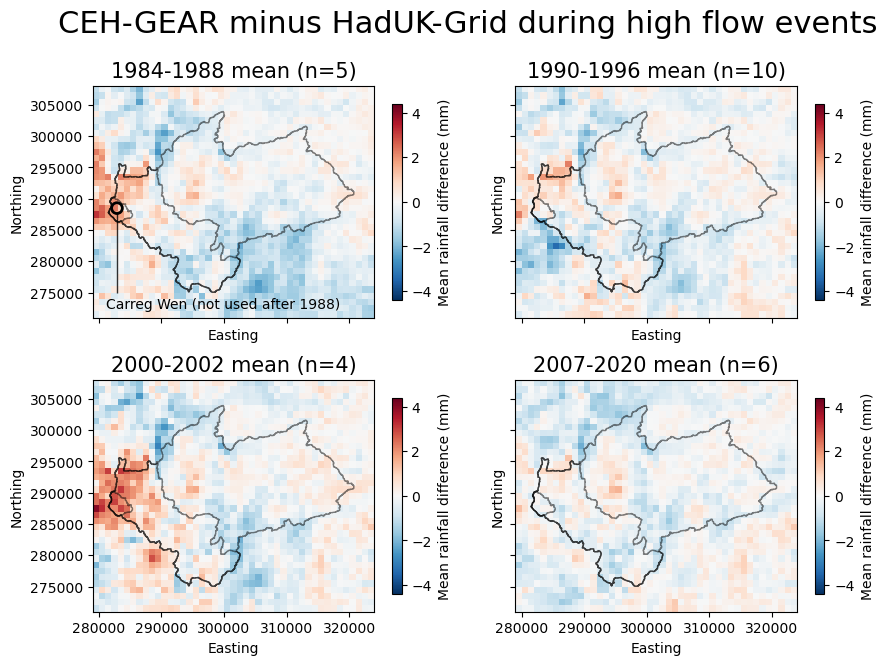

In [142]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

rain_vmin = -4.4
rain_vmax = 4.4
used_cmap = plt.get_cmap('RdBu_r')
cmap_norm = plt.Normalize(rain_vmin, rain_vmax)

counter = 0

for ax, hf_event_group in zip(axes.flatten(), hf_event_groups):
    for ind, flood_date in enumerate(hf_event_group):
        ## get CEH-GEAR data
        ceh_abermule_for_flood = ceh_abermule.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
        ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
        ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood[diff_col_name].mean('time')
        if ind == 0:
            all_ceh_haduk_diff_for_flood_sum = ceh_haduk_diff_for_flood_mean
        else:
            all_ceh_haduk_diff_for_flood_sum += ceh_haduk_diff_for_flood_mean
    ## plot data
    all_ceh_haduk_diff_for_flood_mean = (all_ceh_haduk_diff_for_flood_sum/len(hf_event_group)).load()
    all_ceh_haduk_diff_for_flood_mean.plot(ax=ax, cmap='RdBu_r', vmin=rain_vmin, vmax=rain_vmax, center=0, cbar_kwargs={'label': 'Mean rainfall difference (mm)', 'shrink': 0.8})

    abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
    dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_xlabel('Easting'); ax.set_ylabel('Northing');
    if counter == 0:
        ax.scatter(x=CARREG_COORDS['Easting'], y=CARREG_COORDS['Northing'], marker='o', edgecolor='k', facecolor='None', s=60, linewidths=2)
        ax.vlines(x=CARREG_COORDS['Easting'], ymin=CARREG_COORDS['Northing']-13500, ymax=CARREG_COORDS['Northing']-600, color='k', alpha=.8, linewidth=1)
        ax.text(s='Carreg Wen (not used after 1988)', x=CARREG_COORDS['Easting']-1700, y=CARREG_COORDS['Northing']-16000, color='k', size=10)
        counter += 1
    ax.set_title(f"{hf_event_group[0].year}-{hf_event_group[-1].year} mean (n={len(hf_event_group)})", size=15)
plt.suptitle("CEH-GEAR minus HadUK-Grid during high flow events", size=22)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_event_mean_difference.png', bbox_inches='tight', dpi=200)


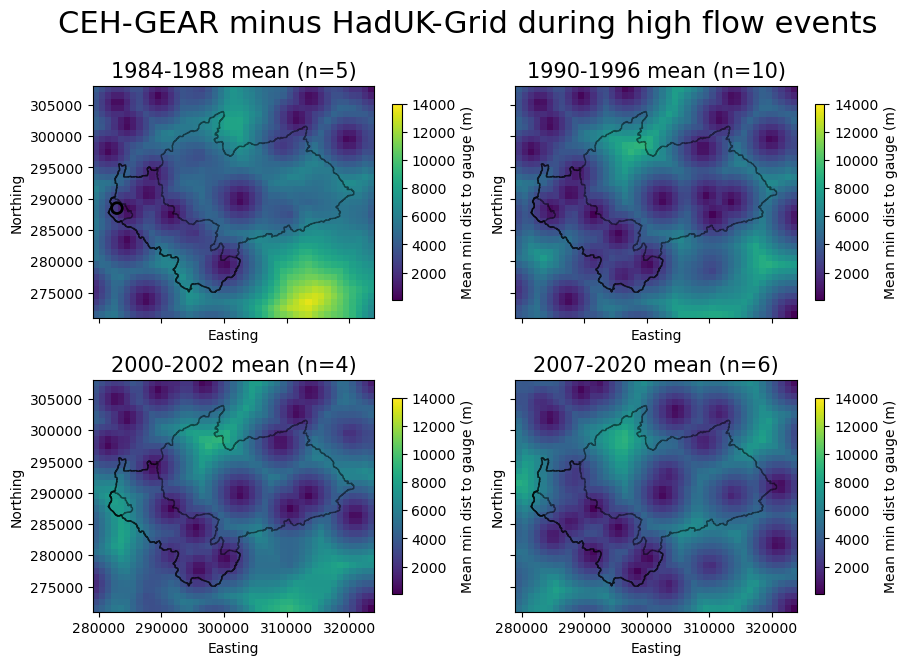

In [151]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7), sharex=True, sharey=True)

rain_vmax = 14000
counter = 0

for ax, hf_event_group in zip(axes.flatten(), hf_event_groups):
    for ind, flood_date in enumerate(hf_event_group):
        ## get CEH-GEAR data
        ceh_abermule_for_flood = ceh_abermule.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
        ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
        ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood['min_dist'].mean('time')
        if ind == 0:
            all_ceh_haduk_diff_for_flood_sum = ceh_haduk_diff_for_flood_mean
        else:
            all_ceh_haduk_diff_for_flood_sum += ceh_haduk_diff_for_flood_mean
    ## plot data
    all_ceh_haduk_diff_for_flood_mean = (all_ceh_haduk_diff_for_flood_sum/len(hf_event_group)).load()
    all_ceh_haduk_diff_for_flood_mean.plot(ax=ax, vmax=rain_vmax, cbar_kwargs={'label': 'Mean min dist to gauge (m)', 'shrink': 0.8})

    abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
    dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_xlabel('Easting'); ax.set_ylabel('Northing');
    if counter == 0:
        ax.scatter(x=CARREG_COORDS['Easting'], y=CARREG_COORDS['Northing'], marker='o', edgecolor='k', facecolor='None', s=60, linewidths=2)
    #     ax.vlines(x=CARREG_COORDS['Easting'], ymin=CARREG_COORDS['Northing']-13500, ymax=CARREG_COORDS['Northing']-600, color='k', alpha=.8, linewidth=1)
    #     ax.text(s='Carreg Wen (not used after 1988)', x=CARREG_COORDS['Easting']-1700, y=CARREG_COORDS['Northing']-16000, color='k', size=10)
        counter += 1
    ax.set_title(f"{hf_event_group[0].year}-{hf_event_group[-1].year} mean (n={len(hf_event_group)})", size=15)
plt.suptitle("CEH-GEAR minus HadUK-Grid during high flow events", size=22)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_event_mean_mindist.png', bbox_inches='tight', dpi=200)


# 4. Compare datasets during high flow events by catchment
[Back to Index](#table-of-contents)

In [152]:
## Functions to mask rainfall to catchments
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * utils.binarize_hght_clip(region_mask).data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    return rainfall_data * region_hght_mask.data



In [153]:
abermule_hght = utils.make_region_hght_clip(abermule_shp, hght_data=severn_hght)
dolwen_hght = utils.make_region_hght_clip(dolwen_shp, hght_data=severn_hght)
plynlimon_hght = utils.make_region_hght_clip(plynlimon_shp, hght_data=severn_hght)


In [154]:
catchments_shp_and_hght = {'Abermule': {'shp': abermule_shp, 'hght': abermule_hght}, \
    'Dolwen': {'shp': dolwen_shp, 'hght': dolwen_hght},\
    'Plynlimon Flume': {'shp': plynlimon_shp, 'hght': plynlimon_hght}}

In [155]:
region_to_examine = 'Abermule'


In [156]:
def get_regline(x, y):
    linreg_coef = np.polyfit(x, y, deg=1)
    linreg_func = np.poly1d(linreg_coef)
    return linreg_func

def plot_scatter_w_regline(x, y, ax, x_pos, y_pos, **kwargs):
    linreg_func = get_regline(x, y)
    rval, pval = scipy.stats.pearsonr(x, y)
    ax.scatter(x, y, **kwargs)
    ax.plot(x, y, 'o', x, linreg_func(x))
    ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=x_pos, y=y_pos)
    return ax

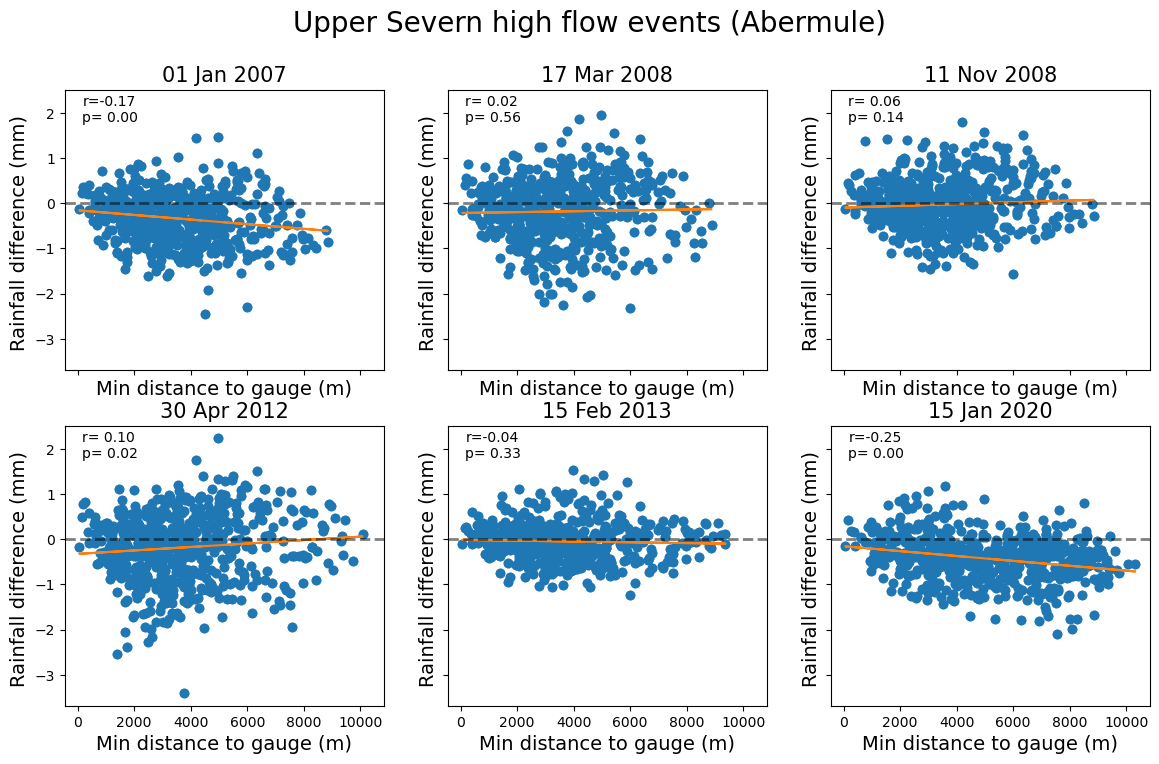

In [160]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)


for flood_date, ax in zip(six_floods_to_view, axes.flatten()):
    ## get CEH-GEAR data
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood.mean('time').load()
    ceh_haduk_diff_for_flood_mean_masked = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght[region_to_examine]['hght'])

    x = ceh_haduk_diff_for_flood_mean_masked['min_dist'].data.flatten()
    y = ceh_haduk_diff_for_flood_mean_masked[diff_col_name].data.flatten()

    ## workaround required when using mask
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    ## Make plot
    plot_scatter_w_regline(x, y, ax, x_pos=170, y_pos=1.8)
    ax.set_title(f'{flood_date.strftime('%d %b %Y')}', size=15)
    ax.set_xlabel("Min distance to gauge (m)", size=14)
    ax.set_ylabel("Rainfall difference (mm) ", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

plt.suptitle(f"Upper Severn high flow events ({region_to_examine})", size=20)
# fig.savefig(f'../figures/upper_severn_floods/{region_to_examine}_flood_events_scatter_mindist.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
- 

In [161]:
abermule_hght_mask = utils.binarize_hght_clip(abermule_hght)
dolwen_hght_mask = utils.binarize_hght_clip(dolwen_hght)
plynlimon_hght_mask = utils.binarize_hght_clip(plynlimon_hght)

In [162]:
def get_gauges_in_each_region_mask(gauge_data):
    abermule_gauge_inds = []
    dolwen_gauge_inds = []
    plynlimon_gauge_inds = []

    for ind, gauge in gauge_data.iterrows():
        if not np.isnan(plynlimon_hght_mask.sel(x=gauge['easting'], y=gauge['northing'], method='nearest')):
            plynlimon_gauge_inds.append(int(gauge['gauge_id']))
            continue
        if not np.isnan(dolwen_hght_mask.sel(x=gauge['easting'], y=gauge['northing'], method='nearest')):
            dolwen_gauge_inds.append(int(gauge['gauge_id']))
            continue
        if not np.isnan(abermule_hght_mask.sel(x=gauge['easting'], y=gauge['northing'], method='nearest')):
            abermule_gauge_inds.append(int(gauge['gauge_id']))
            continue
    return abermule_gauge_inds, dolwen_gauge_inds, plynlimon_gauge_inds


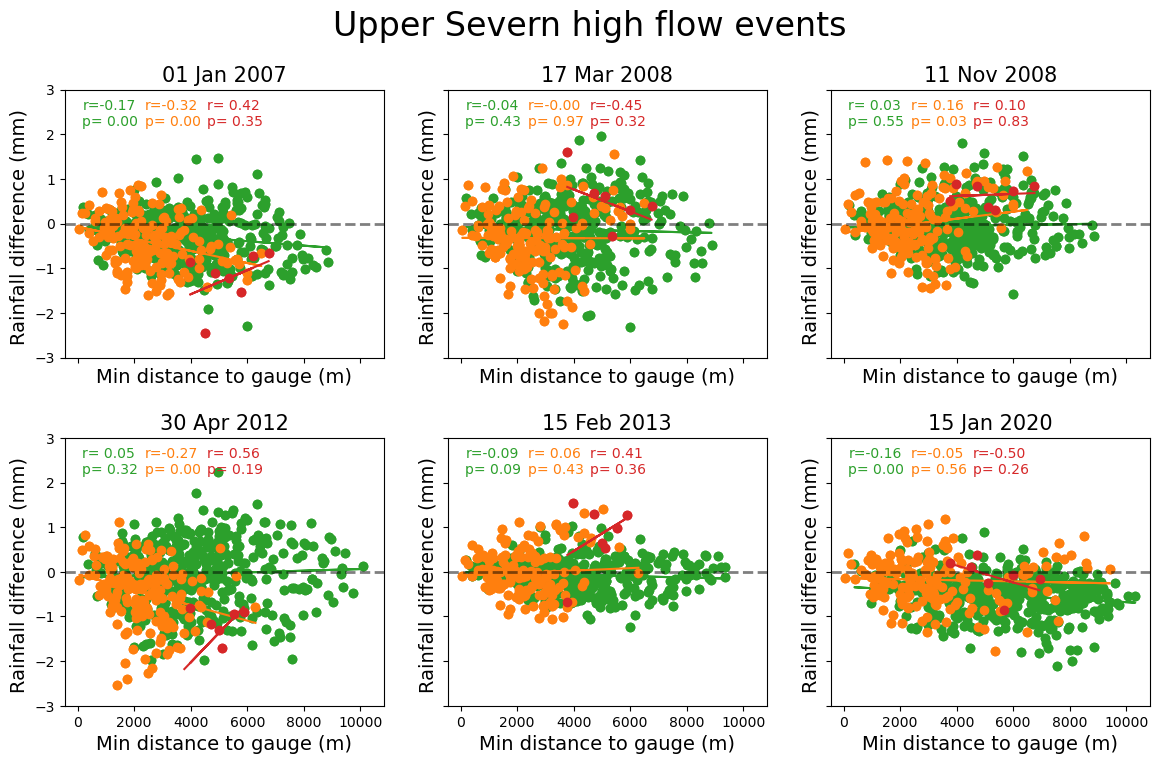

In [181]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

ymin, ymax = -3, 3

for flood_date, ax in zip(six_floods_to_view, axes.flatten()):
    ## get CEH-GEAR data
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood.mean('time').load()
    x_pos, y_pos = 170, 2.2
    for region, color_to_use in zip(catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
        ceh_haduk_diff_for_flood_mean_masked = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght[region]['hght'])

        ## mask out all other regions:
        if region == 'Abermule':
            other_region_mask = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght['Dolwen']['hght'])
            ceh_haduk_diff_for_flood_mean_masked = ceh_haduk_diff_for_flood_mean_masked.where(other_region_mask['rain_mm_diff'].isnull())
        elif region == 'Dolwen':
            other_region_mask = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght['Plynlimon Flume']['hght'])
            ceh_haduk_diff_for_flood_mean_masked = ceh_haduk_diff_for_flood_mean_masked.where(other_region_mask['rain_mm_diff'].isnull())
            x_pos += 2200
        else:
            x_pos += 2200
        x = ceh_haduk_diff_for_flood_mean_masked['min_dist'].data.flatten()
        y = ceh_haduk_diff_for_flood_mean_masked[diff_col_name].data.flatten()

        ## workaround required when using mask
        x = x[np.isfinite(x)]
        y = y[np.isfinite(y)]

        ## Make plot
        linreg_func = get_regline(x, y)
        rval, pval = scipy.stats.pearsonr(x, y)
        ax.scatter(x, y, c=color_to_use)
        ax.plot(x, y, 'o', x, linreg_func(x), c=color_to_use)
        ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=x_pos, y=y_pos, size=10, c=color_to_use)
    ax.set_title(f'{flood_date.strftime('%d %b %Y')}', size=15)
    ax.set_xlabel("Min distance to gauge (m)", size=14)
    ax.set_ylabel("Rainfall difference (mm) ", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)
    ax.set_ylim(ymin, ymax)

plt.subplots_adjust(hspace=.3)
plt.suptitle(f"Upper Severn high flow events", size=24)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_events_scatter_mindist.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
- 

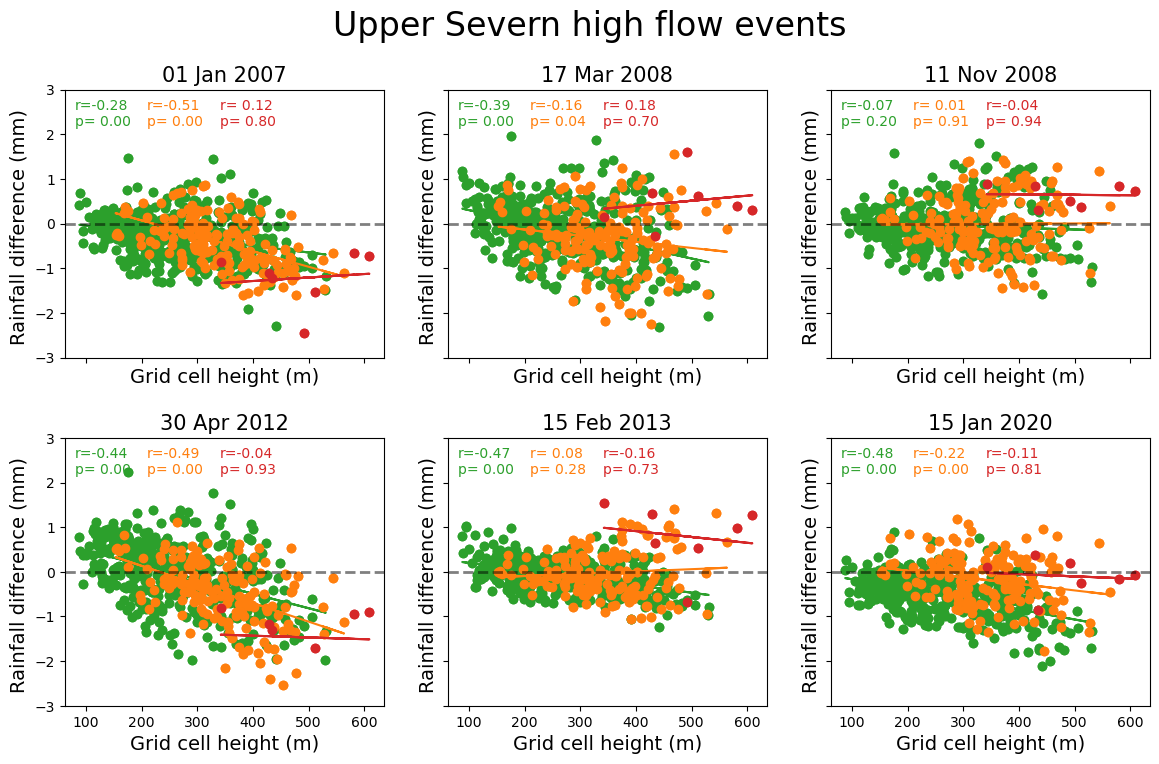

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

ymin, ymax = -3, 3

for flood_date, ax in zip(six_floods_to_view, axes.flatten()):
    ## get CEH-GEAR data
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood.mean('time').load()
    x_pos, y_pos = 80, 2.2
    for region, color_to_use in zip(catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
        ceh_haduk_diff_for_flood_mean_masked = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght[region]['hght'])

        ## mask out all other regions:
        if region == 'Abermule':
            other_region_mask = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght['Dolwen']['hght'])
            ceh_haduk_diff_for_flood_mean_masked = ceh_haduk_diff_for_flood_mean_masked.where(other_region_mask['rain_mm_diff'].isnull())
        elif region == 'Dolwen':
            other_region_mask = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght['Plynlimon Flume']['hght'])
            ceh_haduk_diff_for_flood_mean_masked = ceh_haduk_diff_for_flood_mean_masked.where(other_region_mask['rain_mm_diff'].isnull())
            x_pos += 130
        else:
            x_pos += 130
        x = (ceh_haduk_diff_for_flood_mean_masked['hght']/10).data.flatten()
        y = ceh_haduk_diff_for_flood_mean_masked[diff_col_name].data.flatten()

        ## workaround required when using mask
        x = x[np.isfinite(x)]
        y = y[np.isfinite(y)]

        ## Make plot
        linreg_func = get_regline(x, y)
        rval, pval = scipy.stats.pearsonr(x, y)
        ax.scatter(x, y, c=color_to_use)
        ax.plot(x, y, 'o', x, linreg_func(x), c=color_to_use)
        ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=x_pos, y=y_pos, size=10, c=color_to_use)
    ax.set_title(f'{flood_date.strftime('%d %b %Y')}', size=15)
    ax.set_xlabel("Grid cell height (m)", size=14)
    ax.set_ylabel("Rainfall difference (mm) ", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)
    ax.set_ylim(ymin, ymax)

plt.subplots_adjust(hspace=.3)
plt.suptitle(f"Upper Severn high flow events", size=24)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_events_scatter_height.png', bbox_inches='tight', dpi=200)

### ⭐ Intepretation of above figure:
- 